In [1]:
import numpy as np

# 데이터 전처리

## 정규화

In [2]:
def normalize(x):
    x_max = np.max(x)
    x_min = np.min(x)
    return (x - x_min) / (x_max - x_min)

## 표준화

In [3]:
def standardize(x):
    ave = np.average(x)
    std = np.std(x)
    return (x - ave) / std

## 무상관화

데이터의 각 성분이 관계를 갖고 있는 경우, 이 관계성을 제거하는 것.
예를 들어 위도와 해발고도, 평균 기온 등은 각 데이터 간에는 특별한 관계성이 있는데, 이를 무상관화를 통해 관계성이 제거된 데이터로 변환시킬 수 있다.

## 드랍아웃(dropout)

출력층 이외의 뉴런을 일정한 확률로 무작위 제거하는 방법으로 제거되는 뉴런은 가중치와 편향을 수정할 때마다 바뀐다. 층의 뉴런이 제거되지 않고 남을 확률을 p라고 하면 은닉층은 p=0.5, 입력층은 p=0.8~0.9의 값이 많이 사용된다. 구현이 쉽고 overfit 방지하는 데에 큰 효과가 있다.

# 예제 붓꽃 품종 분류

- 은닉층의 활성화 함수: ReLU
- 출력층의 활성화 함수: 소프트맥스 함수
- 손실 함수: 교차 엔트로피 오차
- 최적화 알고리즘: 확률적 경사 하강법
- 배치 사이즈: 8
- 은닉층의 뉴런 수: 25

Epoch:0/1000 Error_train:1.0954048545075348 Error_test:1.091370031328148
Epoch:100/1000 Error_train:0.17221056125802148 Error_test:0.10448118703646637
Epoch:200/1000 Error_train:0.07679165812618274 Error_test:0.06757807436560137
Epoch:300/1000 Error_train:0.05623229093371445 Error_test:0.07178708806525302
Epoch:400/1000 Error_train:0.03998539466916879 Error_test:0.06803463198278623
Epoch:500/1000 Error_train:0.03204706421154754 Error_test:0.08076281297611662
Epoch:600/1000 Error_train:0.03170480417155741 Error_test:0.08146123229477412
Epoch:700/1000 Error_train:0.015857168735052343 Error_test:0.08962386205590694
Epoch:800/1000 Error_train:0.011344852279943725 Error_test:0.09989964707635991
Epoch:900/1000 Error_train:0.022792341496070005 Error_test:0.10220828862873013


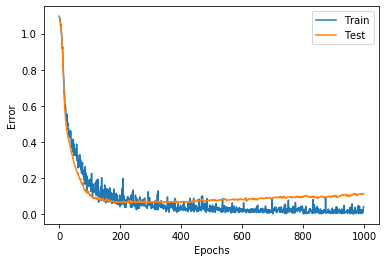

Accuracy Train: 100.0% Accuracy Test: 97.33333333333334%


In [20]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)

ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

correct_data = np.zeros((n_data,3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train,:]
correct_train = correct_data[index_train,:]
input_test = input_data[index_test,:]
correct_test = correct_data[index_test,:]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
        self.h_w = np.zeros((n_upper,n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)

class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        self.grad_x = np.dot(delta, self.w.T)

class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio
        
    def forward(self, x, is_train):
        if is_train:
            rand = np.random.rand(x.shape[0],x.shape[1])
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
            self.y = x * self.dropout
        else:
            self.y = (1-self.dropout_ratio)*x
            
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout
        

n_in = 4
n_mid = 50
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

def forward_propagation(x, is_train=False):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout_2.y)
    
    
def backward_propagation(t):
    output_layer.backward(t)
    dropout_2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)
    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)
    
    
def update_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)
    
#--교차 엔트로피 계산--
def get_error(t, batch_size):
    return -np.sum(t * np.log(output_layer.y + 1e-7))/batch_size


train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

n_batch = n_train // batch_size  #1 epoch당 배치 수
for i in range(epoch):
    forward_propagation(input_train, True)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test)
    error_test = get_error(correct_test, n_test)
    
    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)
    
    if i%interval==0:
        print('Epoch:'+str(i)+'/'+str(epoch),'Error_train:' + str(error_train),'Error_test:'+str(error_test))
        
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)
    
    for j in range(n_batch):
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index,:]
        t=correct_train[mb_index,:]
        
        forward_propagation(x, True)
        backward_propagation(t)
        
        update_wb()
        
plt.plot(train_error_x, train_error_y, label='Train')
plt.plot(test_error_x, test_error_y, label='Test')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Error')

plt.show()

forward_propagation(input_train)
count_train = np.sum(np.argmax(output_layer.y,axis=1)==np.argmax(correct_train,axis=1))

forward_propagation(input_test)
count_test = np.sum(np.argmax(output_layer.y,axis=1)==np.argmax(correct_test,axis=1))

print('Accuracy Train:', str(count_train/n_train*100) + '%',
     'Accuracy Test:', str(count_test/n_test*100) + '%')